In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from common_utils import EmbeddingMatrix, UNK_TOKEN, EMBEDDING_DIM, tokenize, CustomDatasetPreparer, set_seed
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
set_seed(42)

# Part 3. Enhancement
The RNN model used in Part 2 is a basic model to perform the task of sentiment classification. In
this section, you will design strategies to improve upon the previous model you have built. You are
required to implement the following adjustments:

1. Instead of keeping the word embeddings fixed, now update the word embeddings (the same
way as model parameters) during the training process.
2. As discussed in Question 1(c), apply your solution in mitigating the influence of OOV words
and train your model again.
3. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biLSTM model and a biGRU model, incorporating recurrent computations in both directions and
stacking multiple layers if possible.
4. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a Convolutional Neural Network (CNN) to produce sentence representations and perform sentiment
classification.
5. Further improve your model. You are free to use any strategy other than the above mentioned solutions. Changing hyper-parameters or stacking more layers is not counted towards
a meaningful improvement.


## Import dataloaders and pre-trained embeddings from previous parts

In [2]:
BATCH_SIZE = 64
dataset_preparer = CustomDatasetPreparer(
    dataset_name="rotten_tomatoes",
    batch_size=BATCH_SIZE
)

train_loader, val_loader, test_loader = dataset_preparer.get_dataloaders()
word_embeddings = EmbeddingMatrix.load(fast_text=False)
word_embeddings.add_padding()
word_embeddings.add_unk_token()
word_embeddings.unk_idx

16164

## 3(c.1) biLSTM - Naive

Below is the first version of biLSTM which we have tried, which is a naive and simple implementation of the biLSTM model. BiLSTM is able to learn information both from the past and the future sequences in the network, compared to unidirectional which only looks at the past. LSTM makes use of 3 gates, Input gate, Forget gate, and the Output Gate to mimic a behaviour similar to human's and achieve memory persistence through a period of time.

### Definition of BiLSTM Module

In [3]:
class BiLSTM(nn.Module):
    """
    A class implementing a Bidirectional LSTM model for sequence classification.

    """
    def __init__(self, word_embedding, hidden_dim, embedding_dim):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        # Initialize the Embedding layer with pre-trained word embeddings, with freeze=false as required by the assignment
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(word_embedding, dtype=torch.float), freeze=False)
        # Define the LSTM layer with 2 layers and bidirectional
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, bidirectional=True, batch_first=True)
        # Define a dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)
        # Define the fully connected layer with output size of 2 (for binary classification)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, input):
        # Get the input size
        input_size = input.size(0)
        # Pass the input sequence into the embedding layer
        embedded = self.embedding(input)
        # Calculate the sequence lengths for each batch element
        seq_lengths = torch.tensor([len(seq) for seq in embedded], dtype=torch.int64)
        # Pack the padded sequences
        packed_seqs = pack_padded_sequence(embedded, seq_lengths, batch_first=True, enforce_sorted=False)
        # Pass the packed sequences through the LSTM layer to get the output and hidden states
        lstm_out, (hidden_state_T, cell_state_T) = self.lstm(packed_seqs)
        # Unpack the padded sequences back to normal tensors
        unpacked_seq, _ = pad_packed_sequence(lstm_out, batch_first=True)
        # Concatenate the final forward and backward hidden states from each sequence in the batch
        # unpacked_seq[:,:,0:self.hidden_dim] is the forward direction and unpacked_seq[:,:,self.hidden_dim:] is the backward direction
        unpacked_seq = unpacked_seq[:, :, :self.hidden_dim] + unpacked_seq[:, :, self.hidden_dim:]
        # Apply dropout to prevent overfitting
        dropout = self.dropout(unpacked_seq)
        # Use adaptive max pooling to reduce the dimensionality of the output sequence
        max_pooled = F.adaptive_max_pool1d(dropout.permute(0, 2, 1), (1,)).view(input_size, -1)
        # Pass to the fully connected layer to get the final output
        fc_out = self.fc(max_pooled)

        return fc_out

### Model creation

In [4]:
"""
Model setting configuration
"""
# device = torch.device("cpu")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
hidden_dim = 8
max_norm = 5
learning_rate = 1e-4
epochs = 50
es_patience = 15

"""
Model definition
"""
# Create LSTM model
model = BiLSTM(word_embeddings.embedding_matrix,hidden_dim,word_embeddings.dimension)
print(model)

# Create loss function
loss_fn = nn.CrossEntropyLoss()
# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
# Create step LR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

model = model.to(device)
loss_fn = loss_fn.to(device)

cuda
BiLSTM(
  (embedding): Embedding(16165, 100)
  (lstm): LSTM(100, 8, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=8, out_features=2, bias=True)
)


### Train-Test functions

In [5]:
# function to predict accuracy
def acc(pred, label):
    _, predicted = torch.max(pred, 1)
    return torch.sum(predicted == label).item()

# training
def train_loop(train_loader, model, loss_fn, optimizer, scheduler, max_norm=3):
    train_loss = []
    train_acc = 0.0
    model.train()
    for batch in train_loader:
        X, _, _, Y = batch
        X, Y = X.to(device), Y.to(device)

        optimizer.zero_grad()
        set_seed(42)  # https://datascience.stackexchange.com/a/56615 bug?
        output = model(X)
        # print(output)
        # print(Y)
        # calculate the loss and perform backpropagation
        loss = loss_fn(output,Y)
        loss.backward()
        train_loss.append(loss.item())
        # calculating accuracy
        accuracy = acc(output, Y)
        train_acc += accuracy
        #helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    # scheduler.step()
    return epoch_train_loss, epoch_train_acc

# testing
def test_loop(test_loader, model, loss_fn):

    test_loss = []
    test_acc = 0.0
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            X, _, _, Y = batch
            X, Y = X.to(device), Y.to(device)

            optimizer.zero_grad()
            set_seed(42)
            output = model(X)

            # calculate the loss and perform backpropagation
            loss = loss_fn(output,Y)
            test_loss.append(loss.item())
            # calculating accuracy
            accuracy = acc(output,Y)
            test_acc += accuracy

    epoch_test_loss = np.mean(test_loss)
    epoch_test_acc = test_acc/len(test_loader.dataset)

    return epoch_test_loss, epoch_test_acc

In [6]:
best_val_loss = np.inf
best_acc = 0
train_loss_, train_acc_, val_loss_, val_acc_ = [], [], [], []
# start training process

from tqdm import tqdm
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer,scheduler, max_norm)
    val_loss, val_acc = test_loop(val_loader, model, loss_fn)

    train_loss_.append(train_loss), train_acc_.append(train_acc)
    val_loss_.append(val_loss), val_acc_.append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        best_model = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= es_patience:
            print(f'early stopping after {epoch+1} epochs')
            print(f'best val loss: {best_val_loss}')
            print(f'best accuracy on val set: {best_acc}')
            break

    if epoch % 10 == 0:
        print(f"epoch {epoch+1}, train_loss {train_loss:>7f} train_acc {train_acc:>4f}, val_loss {val_loss:>7f}, val_acc {val_acc:>4f}")

  2%|▏         | 1/50 [00:01<01:15,  1.53s/it]

epoch 1, train_loss 0.697422 train_acc 0.502579, val_loss 0.693333, val_acc 0.504690


 22%|██▏       | 11/50 [00:17<01:03,  1.62s/it]

epoch 11, train_loss 0.500301 train_acc 0.768464, val_loss 0.592520, val_acc 0.718574


 42%|████▏     | 21/50 [00:32<00:45,  1.56s/it]

epoch 21, train_loss 0.249812 train_acc 0.911020, val_loss 0.518284, val_acc 0.751407


 62%|██████▏   | 31/50 [00:48<00:31,  1.66s/it]

epoch 31, train_loss 0.122534 train_acc 0.965299, val_loss 0.525390, val_acc 0.750469


 72%|███████▏  | 36/50 [00:58<00:22,  1.62s/it]

early stopping after 37 epochs
best val loss: 0.51705941733192
best accuracy on val set: 0.7532833020637899


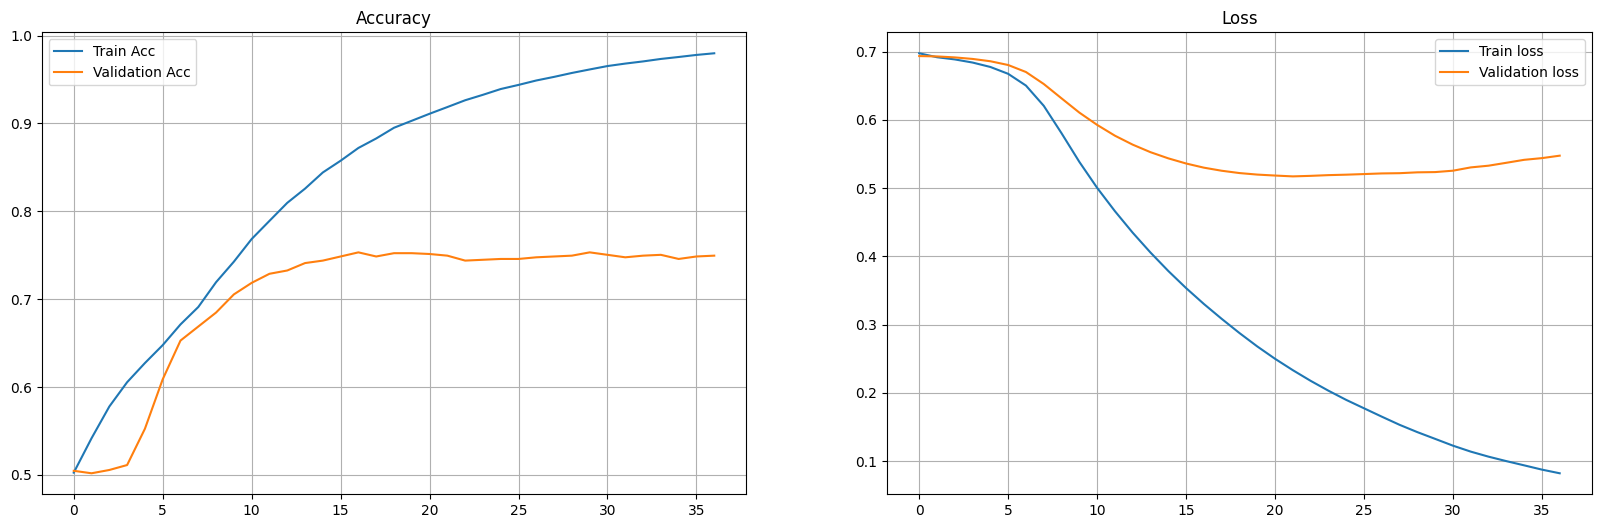

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc_, label='Train Acc')
plt.plot(val_acc_, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(train_loss_, label='Train loss')
plt.plot(val_loss_, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

## 3(C) biLSTM - (naive) Results

In [8]:
test_loss, test_acc = test_loop(test_loader, model, loss_fn)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")

test_loss 0.516879, test_acc 0.771107


For this naive simple model, we received a test accuracy of 0.771 on the test set, which is decent but has room for improvement. Hence, we will be taking a look in the next notebook to see if we can improve our results with an improved biGRU model, and try apply biLSTM to it as well since the structures of both models are quite similar.

# Question 3. Enhancement
(a) Report the accuracy score on the test set when the word embeddings are updated (Part 3.1).
   
(b) Report the accuracy score on the test set when applying your method to deal with OOV words
in Part 3.2.
   
(c) Report the accuracy scores of biLSTM and biGRU on the test set (Part 3.3).
   
(d) Report the accuracy scores of CNN on the test set (Part 3.4).
   
(e) Describe your final improvement strategy in Part 3.5. Report the accuracy on the test set
using your improved model.
   
(f) Compare the results across different solutions above and describe your observations with possible discussions.
